시간적 그래프 인공신경망

정적그래프

In [18]:
# 정적그래프 : 의미는 변하지만 그래프의 구조는 고정된 그래프
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

In [2]:
dataset = WikiMathsDatasetLoader().get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset,train_ratio=0.5)
# 학습셋 : 이른 시점의 스냅샷 / 평가셋 : 늦은 시점의 스냅샷
print(dataset[0])

Data(x=[1068, 8], edge_index=[2, 27079], edge_attr=[27079], y=[1068])


In [3]:
train_dataset.snapshot_count #스냅샷 갯수

361

In [4]:
import pandas as pd
mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases,columns=['mean'])
df['std'] = pd.DataFrame(std_cases,columns=['std'])
df['rolling'] = df['mean'].rolling(7).mean()

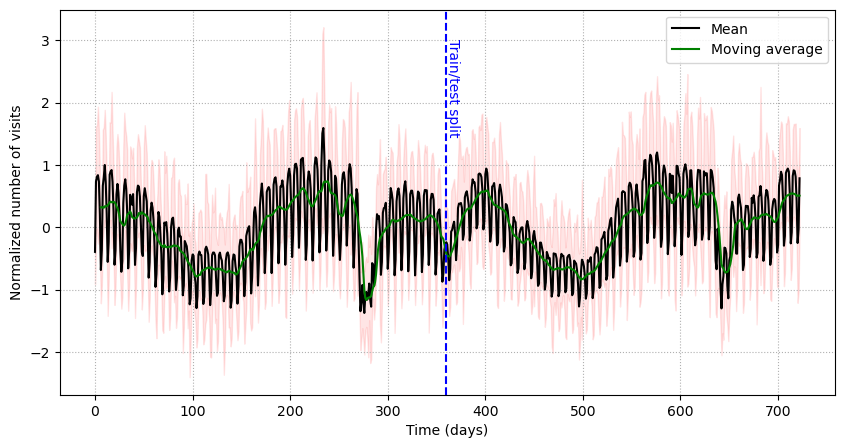

In [5]:
#시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

In [69]:
import torch
import torch.nn.functional as F
class TemporalGNN(torch.nn.Module):
    def __init__(self,node_count,dim_in): # TGNN은 노드 수, 입력차원 등 2가지 파라미터를 입력값으로 가진다.
        super().__init__()
        # TGNN은 두 개의 레이어를 가진다.
        self.recurrent = EvolveGCNH(node_count,dim_in) # EvolveGCN-H 레이어 (노드 특성값이 필수적일 때, 노드 임베딩에 사용)
        self.linear = torch.nn.Linear(dim_in,1) # 예측

    def forward(self,x,edge_index,edge_attr):
        h1 = self.recurrent(x,edge_index,edge_attr).clone()
        h2 = F.relu(h1)
        h3 = self.linear(h2)
        return h3

In [ ]:
model = TemporalGNN(dataset[0].x.shape[0],dataset[0].x.shape[1]) # 노드의 갯수와 특성값 차원을 입력
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
print(model)

TemporalGNN(
  (recurrent): EvolveGCNH(
    (pooling_layer): TopKPooling(8, ratio=0.00749063670411985, multiplier=1.0)
    (recurrent_layer): GRU(8, 8)
    (conv_layer): GCNConv_Fixed_W(8, 8)
  )
  (linear): Linear(in_features=8, out_features=1, bias=True)
)


In [1]:
# model.train()
# for epoch in range(50):
#     for i, snapshot in enumerate(train_dataset):
#         optimizer.zero_grad()
#         y_pred = model(snapshot.x,snapshot.edge_index,snapshot.edge_attr)
#         loss = torch.mean((y_pred-snapshot.y)**2) # MSE Loss
#         loss.backward() # <- 버전 문제로 코랩으로 보기..
#         optimizer.step()
        

동적 그래프(MPNN-LSTM)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

In [ ]:
dataset= EnglandCovidDatasetLoader().get_dataset(lags=14) # 노드의 특성값을 14
# 최근 14일 동안의 정보

In [14]:
dataset[0].x

tensor([[-1.4697, -1.9283, -1.6990,  ...,  0.0207,  0.0207, -0.5526],
        [-1.2510, -1.1812, -1.3208,  ..., -0.6226, -0.9019, -0.5528],
        [-1.0934, -1.0934, -1.0934,  ..., -0.7090, -0.5168, -0.5168],
        ...,
        [-1.0005, -1.0802, -0.7611,  ..., -0.0432,  0.6748,  0.7546],
        [-0.8818, -0.8818, -0.6325,  ...,  1.1751,  1.5490,  2.1723],
        [-1.1665, -1.1665, -0.4823,  ...,  0.7150,  0.5440, -0.1402]])

In [15]:
train_dataset, test_dataset = temporal_signal_split(dataset,train_ratio=0.8)

Text(0, 0.5, 'Mean normalized number of cases')

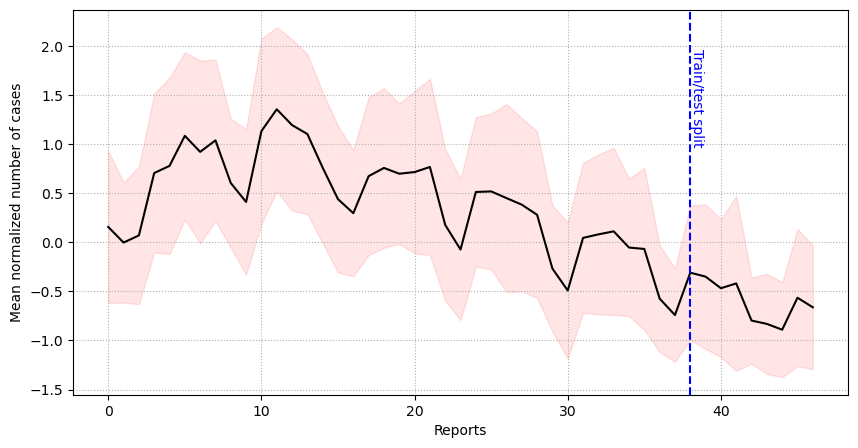

In [16]:
#시각화
mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
                         
plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Reports')
plt.ylabel('Mean normalized number of cases')

In [24]:
from torch_geometric_temporal.nn.recurrent import MPNNLSTM
import torch
class TemporalGNN(torch.nn.Module):
    def __init__(self,dim_in,dim_h,num_nodes):
        super().__init__()
        self.recurrent = MPNNLSTM(dim_in,dim_h,num_nodes,1,0.5)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear = torch.nn.Linear(2*dim_h + dim_in,1) # 현재, 셸, 은닉
    
    def forward(self,x,edge_index,edge_weight):
        h = self.recurrent(x,edge_index,edge_weight).relu()
        h = self.dropout(h)
        h = self.linear(h).tanh()
        return h

In [25]:
model = TemporalGNN(dataset[0].x.shape[1],64,dataset[0].x.shape[0])
print(model)


TemporalGNN(
  (recurrent): MPNNLSTM(
    (_convolution_1): GCNConv(14, 64)
    (_convolution_2): GCNConv(64, 64)
    (_batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_recurrent_1): LSTM(128, 64)
    (_recurrent_2): LSTM(64, 64)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=142, out_features=1, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
model.train()
for epoch in range(100):
    loss = 0
    for i,snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x,snapshot.edge_index,snapshot.edge_attr)
        loss = loss + torch.mean(y_pred-snapshot.y**2)
    loss = loss / (i+1) # 총 스냅샷에 대한 로스 총합을 전체 스냅샷 갯수로 나눔
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [27]:
model.eval()
loss = 0
for i,snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x,snapshot.edge_index,snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE : {loss.item():.4f}')

MSE : 0.6024


Text(0, 0.5, 'Mean normalized number of cases')

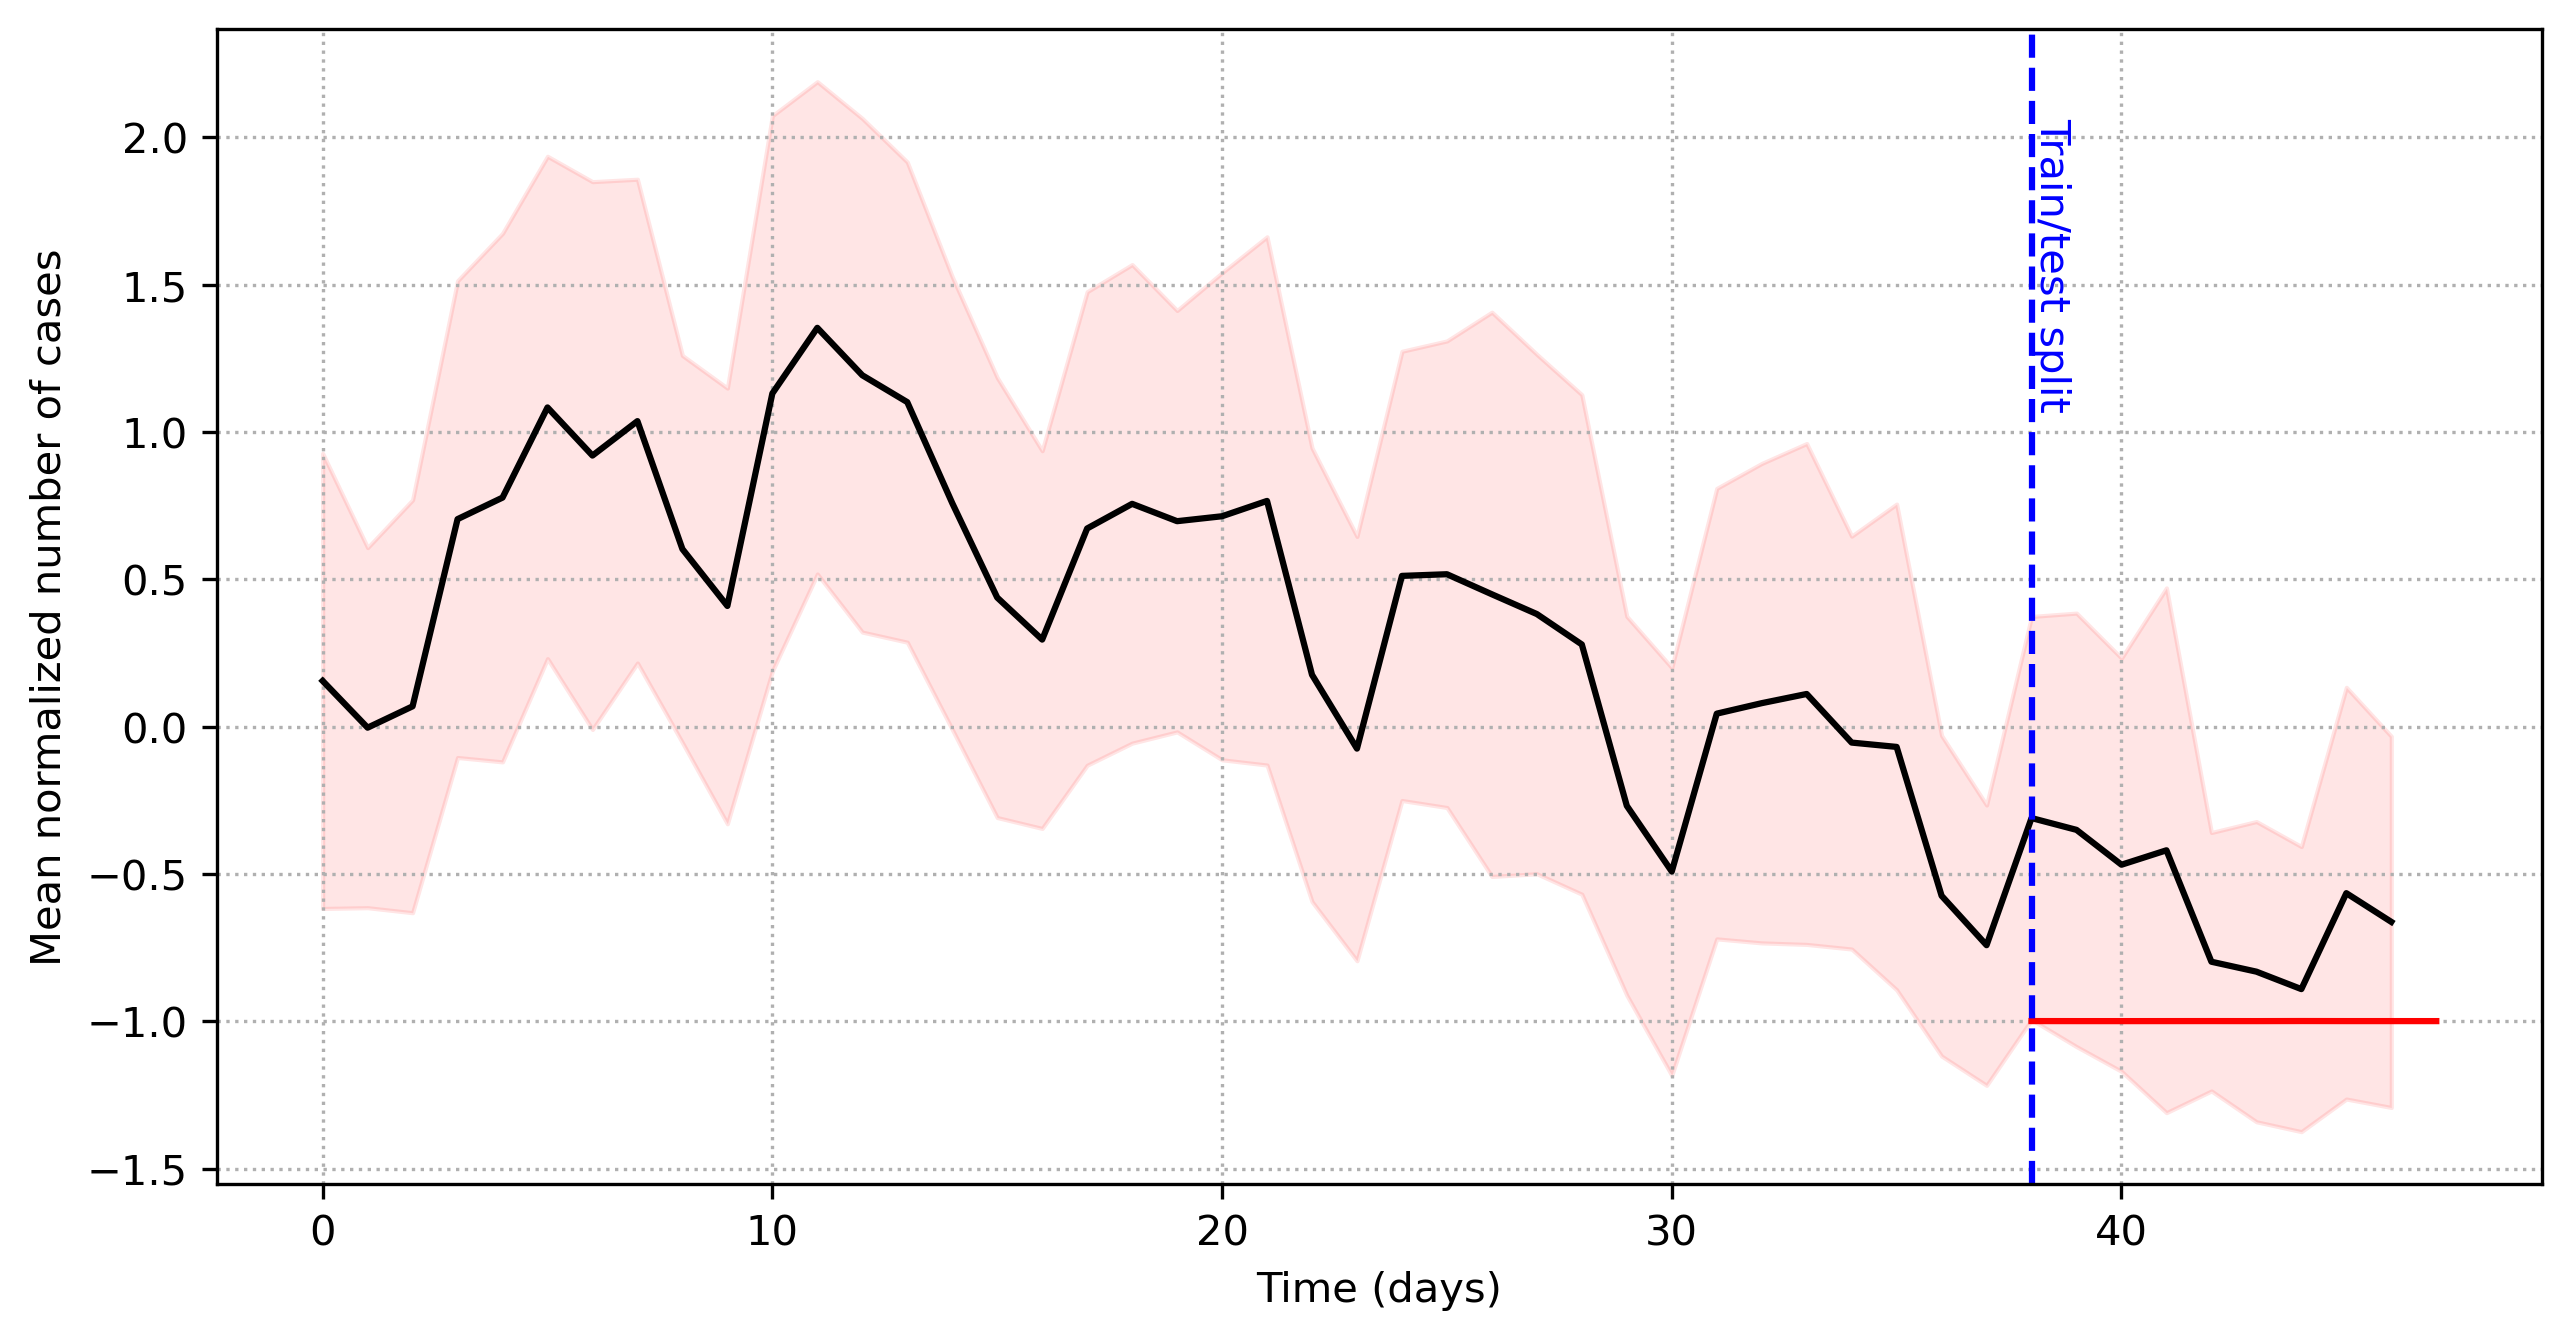

In [28]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-')
plt.plot(range(38,48), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1.1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Mean normalized number of cases')

<Axes: >

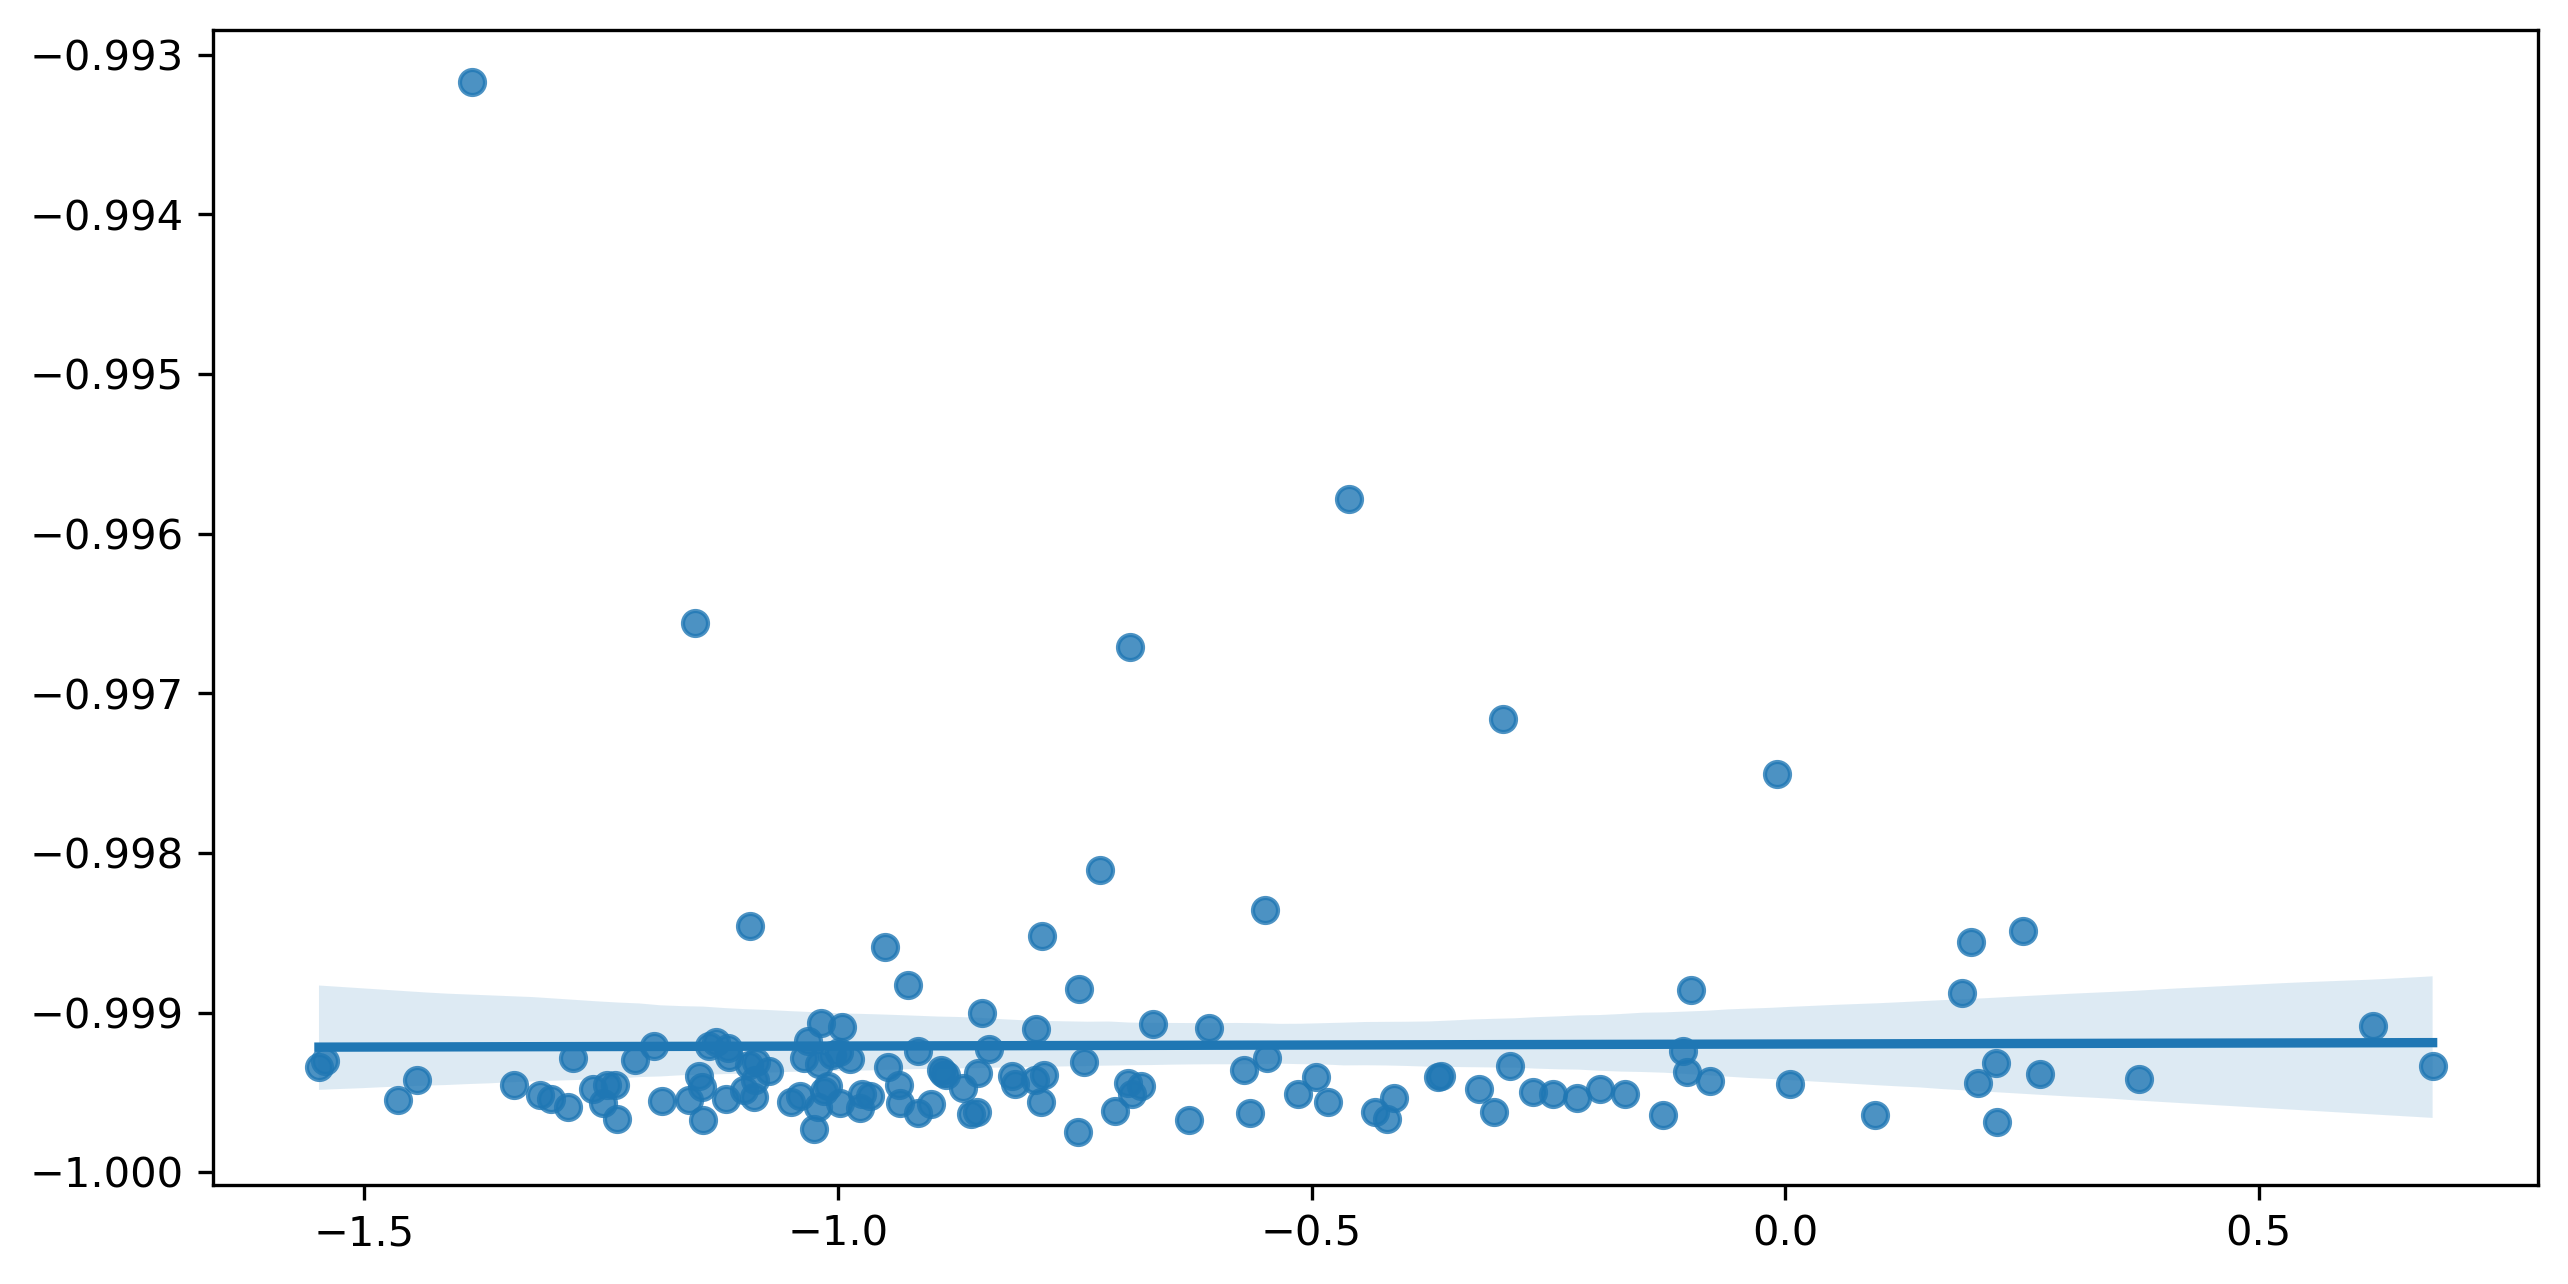

In [29]:
import seaborn as sns

y_pred = model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()

plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)